Reference: https://www.kaggle.com/code/finlay/shopee-products-matching-text-part-english

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import gc

In [2]:
DATA_PATH = '../input/shopee-product-matching/'

def getMetric(col):
    def f1score(row):
        n = len( np.intersect1d(row.target,row[col]) )
        return 2*n / (len(row.target) + len(row[col]))
    return f1score

train = pd.read_csv(DATA_PATH + 'train.csv')
train['image'] = DATA_PATH + 'train_images/' + train['image']
target_mapping = train.groupby('label_group').posting_id.agg('unique').to_dict()
train['target'] = train.label_group.map(target_mapping)

In [3]:
train = train.sort_values(by='label_group')
train['title'] = train['title'].str.lower()
train.head()

posting_id                                              image  \
3874   train_1646767365  ../input/shopee-product-matching/train_images/...   
31859  train_1528423085  ../input/shopee-product-matching/train_images/...   
6738    train_398181303  ../input/shopee-product-matching/train_images/...   
7613   train_2865605743  ../input/shopee-product-matching/train_images/...   
12367  train_1382500866  ../input/shopee-product-matching/train_images/...   

            image_phash                                              title  \
3874   e925873ed09cd08f  sarung celana wadimor original 100% dewasa dan...   
31859  ea97861c926a71e3  warna random acak sarung celana wadimor murah ...   
6738   e9b5833e929e909c    sarung celana wadimor dewasa hitam polos sarcel   
7613   bfc3cc1cc636c14c  wall sticker / wallsticker -  submarine measur...   
12367  838436c07dff19e4  reliza wall sticker pengukur tinggi badan jera...   

       label_group                                             target  
3874        258047  [train_1646767365, train_398181303, train_1528...  
31859       258047  [train_1646767365, train_398181303, train_1528...  
6738        258047  [train_1646767365, train_398181303, train_1528...  
7613        297977               [train_2865605743, train_1382500866]  
12367       297977               [train_2865605743, train_1382500866]

# 1 Edit Distance

https://stackoverflow.com/questions/2460177/edit-distance-in-python

Here just try word intersection.

In [4]:
def title_dist_intersection(s1, s2):
    s1_word = set(s1.split(' '))
    s2_word = set(s2.split(' '))
    return 1 - len((s1_word.intersection(s2_word))) / len(s1_word.union(s2_word))

In [5]:
# same group
title_dist_intersection(train['title'].iloc[0], train['title'].iloc[1])

0.8

In [6]:
# same group
title_dist_intersection(train['title'].iloc[0], train['title'].iloc[2])

0.5

In [7]:
# different group
title_dist_intersection(train['title'].iloc[0], train['title'].iloc[1000])

0.9565217391304348

In [8]:
# different group
title_dist_intersection(train['title'].iloc[0], train['title'].iloc[2000])

1.0

# 2 TF-IDF

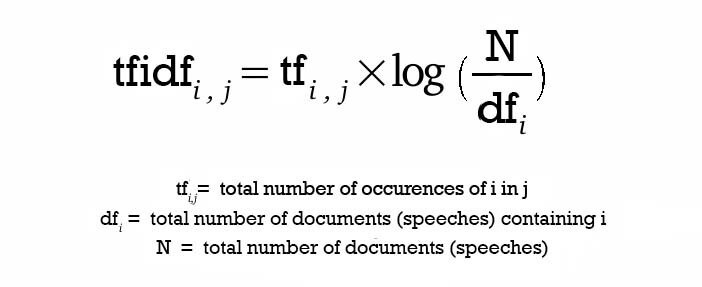

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# a trivial example 
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())
print(X.shape)

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
(4, 9)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [10]:
# a trivial example using uni- and bi-gram
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())
print(X.shape)

['and', 'and this', 'document', 'document is', 'first', 'first document', 'is', 'is the', 'is this', 'one', 'second', 'second document', 'the', 'the first', 'the second', 'the third', 'third', 'third one', 'this', 'this document', 'this is', 'this the']
(4, 22)


In [11]:
# fit training examples
model = TfidfVectorizer(stop_words=None, binary=True, max_features=55000)
text_embeddings = model.fit_transform(train.title).toarray()
print('text embeddings shape',text_embeddings.shape)

text embeddings shape (34250, 25069)


In [12]:
import torch

text_embeddings = torch.from_numpy(text_embeddings).cuda()

preds = []
CHUNK = 1024 * 2

print('Finding similar titles...')

CTS = len(train) // CHUNK
if len(train) % CHUNK != 0: 
    CTS += 1
text_ids = None
    
for j in range(CTS):
    a = j * CHUNK
    b = (j + 1) * CHUNK
    b = min(b, len(train))
    print('chunk', a, 'to', b)
    
    cts = torch.matmul(text_embeddings, text_embeddings[a:b].T).T
    cts = cts.data.cpu().numpy()
    for k in range(b - a):
        idx = np.where(cts[k,] > 0.6)[0]
        o = train.iloc[idx].posting_id.values
        preds.append(o)
        
    del cts
    torch.cuda.empty_cache()
    
del text_embeddings

train['oof_text'] = preds

Finding similar titles...
chunk 0 to 2048
chunk 2048 to 4096
chunk 4096 to 6144
chunk 6144 to 8192
chunk 8192 to 10240
chunk 10240 to 12288
chunk 12288 to 14336
chunk 14336 to 16384
chunk 16384 to 18432
chunk 18432 to 20480
chunk 20480 to 22528
chunk 22528 to 24576
chunk 24576 to 26624
chunk 26624 to 28672
chunk 28672 to 30720
chunk 30720 to 32768
chunk 32768 to 34250


In [13]:
from collections import Counter

# count most frequent words
word_counter = Counter(' '.join(train['title'].values).split(' '))
most_occur = pd.DataFrame({'word': word_counter.keys(), 'count': word_counter.values()})
most_occur = most_occur[most_occur['word'].apply(len) > 1]

most_occur = most_occur.sort_values(by='count', ascending=False)
most_occur.head(10)

word  count
7        anak   1916
111    wanita   1820
3    original   1681
14      murah   1363
149       tas   1192
6         dan   1157
378      pria   1122
946    masker   1111
110     untuk   1068
72       bayi   1061

# 3 BM25

BM25 improves upon TF-IDF. 

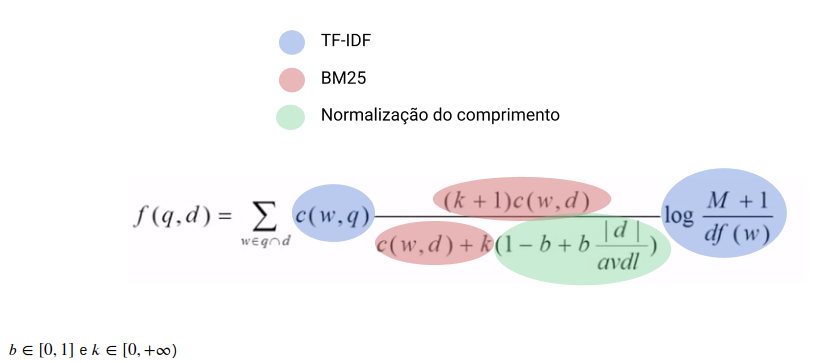

https://github.com/dorianbrown/rank_bm25,
https://www.kaggle.com/ideanlabib/bm25-search-query-similarity-ranking/

In [14]:
!pip install rank_bm25

In [15]:
from rank_bm25 import BM25Okapi
from nltk.tokenize import word_tokenize

In [16]:
train_title_token = train['title'].apply(lambda x: word_tokenize(x))
bm25 = BM25Okapi(train_title_token)

In [17]:
ids = bm25.get_scores(train_title_token.iloc[200])
idx = np.where(ids > 50)[0]
print(ids[idx])
train.iloc[idx]

[67.97019803 52.92810898 51.13522523]


posting_id                                              image  \
29449  train_2181332714  ../input/shopee-product-matching/train_images/...   
25246  train_4129791793  ../input/shopee-product-matching/train_images/...   
30719  train_3493652138  ../input/shopee-product-matching/train_images/...   

            image_phash                                  title  label_group  \
29449  bb39c4c6c6399a91  bedak salicyl 60gr | bedak salicyl kf     25802082   
25246  bb39c4c6c6399a91                     bedak salicyl 60gr     25802082   
30719  b987860f3b78c664                  salicyl bedak kf 60ml     25802082   

                                                  target  \
29449  [train_4129791793, train_1553039102, train_218...   
25246  [train_4129791793, train_1553039102, train_218...   
30719  [train_4129791793, train_1553039102, train_218...   

                                                oof_text  
29449  [train_2181332714, train_4129791793, train_349...  
25246  [train_2181332714, train_4129791793, train_349...  
30719  [train_2181332714, train_4129791793, train_349...

In [18]:
ids = bm25.get_scores(train_title_token.iloc[1000])
idx = np.where(ids > 50)[0]
print(ids[idx])
train.iloc[idx]

[61.29051863 50.36337052 50.36337052 74.6285323  50.36337052 75.25192355
 90.90745136 78.97894391 97.31959375]


posting_id                                              image  \
24504  train_1165058967  ../input/shopee-product-matching/train_images/...   
3165   train_2823824337  ../input/shopee-product-matching/train_images/...   
8551   train_1831498823  ../input/shopee-product-matching/train_images/...   
2207   train_3597470302  ../input/shopee-product-matching/train_images/...   
13444  train_2857221499  ../input/shopee-product-matching/train_images/...   
115     train_404207615  ../input/shopee-product-matching/train_images/...   
7354   train_3960172945  ../input/shopee-product-matching/train_images/...   
28958   train_530505223  ../input/shopee-product-matching/train_images/...   
5806   train_3990088467  ../input/shopee-product-matching/train_images/...   

            image_phash                                              title  \
24504  e1729e67c63460cd                   natur hair tonic aloe vera 90 ml   
3165   e1729e67c63460d9                    natur hair tonic gingseng 90 ml   
8551   e8ce87079771d170                    natur hair tonic gingseng 90 ml   
2207   eec8c0cdcf829596                    natur hair tonic aloe vera 90ml   
13444  e6cecc64c9319993                    natur hair tonic gingseng 90 ml   
115    ae2ed1d1d1d12ad8        natur hair tonic ginseng dan aloe vera 90ml   
7354   d8c327356e1c1f38  bpom - natur hair tonic 90ml / natur hair toni...   
28958  9de1c616323b694b  [bpom] natur hair tonic 90ml / hair tonic gins...   
5806   811d7e697a6619e4  original natur hair tonic 90ml bpom / hair ton...   

       label_group                                             target  \
24504    122550860  [train_404207615, train_3597470302, train_2823...   
3165     122550860  [train_404207615, train_3597470302, train_2823...   
8551     122550860  [train_404207615, train_3597470302, train_2823...   
2207     122550860  [train_404207615, train_3597470302, train_2823...   
13444    122550860  [train_404207615, train_3597470302, train_2823...   
115      122550860  [train_404207615, train_3597470302, train_2823...   
7354     122550860  [train_404207615, train_3597470302, train_2823...   
28958    122550860  [train_404207615, train_3597470302, train_2823...   
5806     122550860  [train_404207615, train_3597470302, train_2823...   

                                                oof_text  
24504  [train_1165058967, train_2823824337, train_183...  
3165   [train_1165058967, train_2823824337, train_183...  
8551   [train_1165058967, train_2823824337, train_183...  
2207   [train_1165058967, train_3597470302, train_404...  
13444  [train_1165058967, train_2823824337, train_183...  
115    [train_1165058967, train_3597470302, train_404...  
7354   [train_3597470302, train_404207615, train_3960...  
28958  [train_3597470302, train_404207615, train_3960...  
5806   [train_3597470302, train_404207615, train_3960...

# 4 Word2Vec

In [19]:
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors

vectors = KeyedVectors.load_word2vec_format("../input/glove2word2vec/glove_w2v.txt")

In [20]:
text_embeddings = []
for title in tqdm(train_title_token[:]):
    title_feat = []
    for word in title:
        if word in vectors:
            title_feat.append(vectors[word])
    
    if len(title_feat) == 0:
        title_feat = np.random.rand(200)
    else:
        # max-pooling
        # mean-pooling
        # IDF
        # SIF
        title_feat = np.vstack(title_feat).max(0)
        
    text_embeddings.append(title_feat)

  0%|          | 0/34250 [00:00<?, ?it/s]

In [21]:
from sklearn.preprocessing import normalize

text_embeddings = normalize(np.vstack(text_embeddings))

text_embeddings = torch.from_numpy(text_embeddings).cuda()

In [22]:
preds = []
CHUNK = 1024 * 4

print('Finding similar images...')

CTS = len(text_embeddings) // CHUNK
if len(text_embeddings) % CHUNK != 0:
    CTS += 1
    
for j in range(CTS):
    a = j * CHUNK
    b = (j + 1) * CHUNK
    b = min(b, len(train))
    print('chunk', a, 'to', b)
    
    cts = torch.matmul(text_embeddings, text_embeddings[a:b].T).T
    cts = cts.data.cpu().numpy()
    for k in range(b - a):
        idx = np.where(cts[k,] > 0.93)[0]
        o = train.iloc[idx].posting_id.values
        preds.append(o)
        
    del cts
    torch.cuda.empty_cache()

Finding similar images...
chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


In [23]:
train['oof_w2v'] = preds

### Train Your Own Word2Vec

* https://machinelearningmastery.com/develop-word-embeddings-python-gensim/
* https://radimrehurek.com/gensim/models/word2vec.html

In [24]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [25]:
common_texts

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]

# 5 Bert

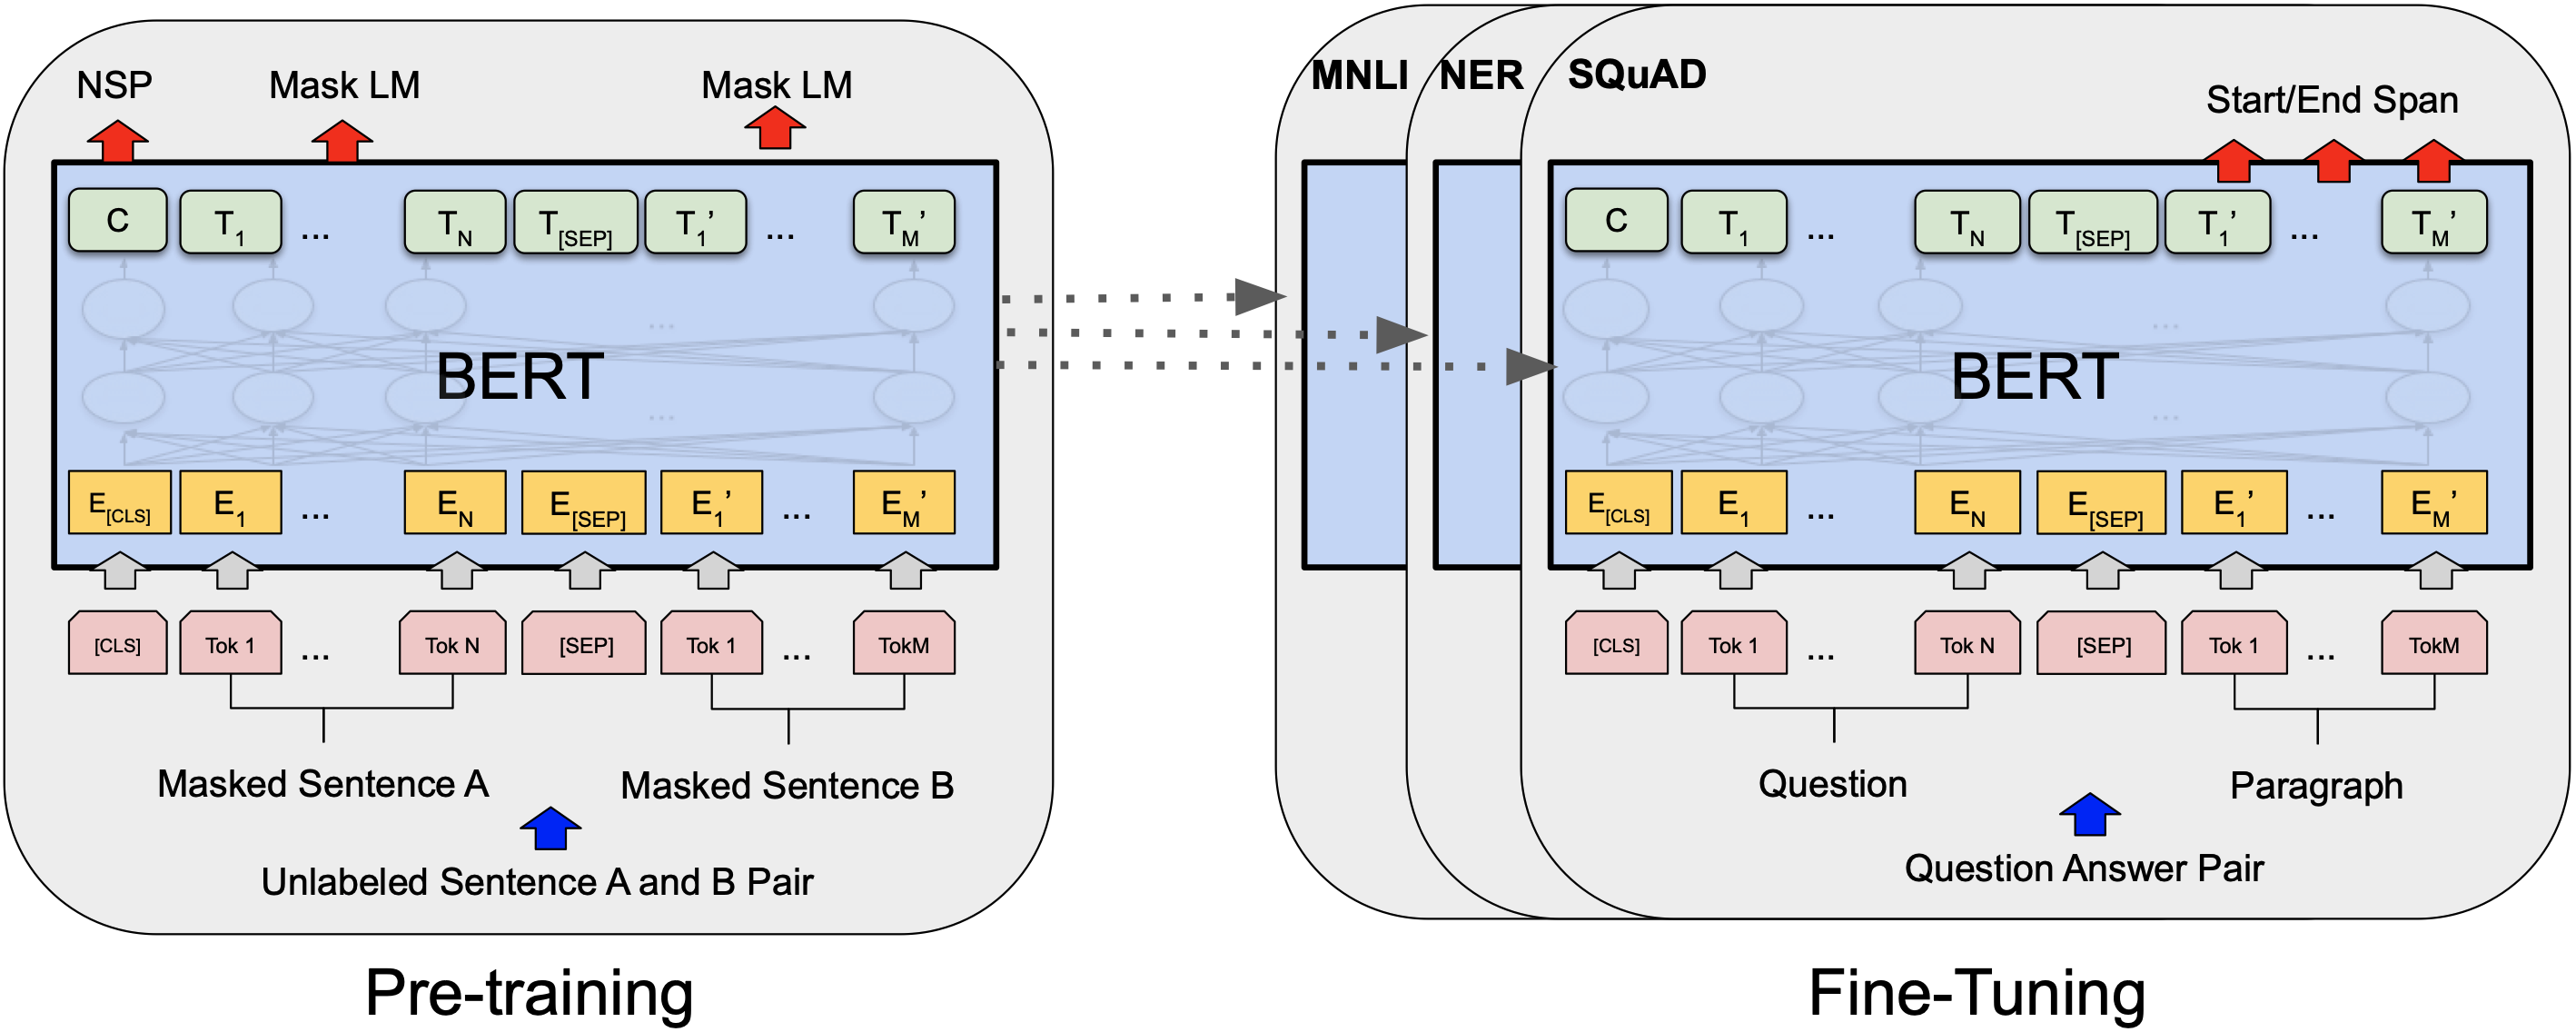

In [26]:
# combine tf-idf and word2vec to retrieve similar examples
# which can be used as positive/negative training examples

def combine_for_oof(row):
    x = np.concatenate([row.oof_text, row.oof_w2v])
    return np.unique(x)

train['oof'] = train.apply(combine_for_oof, axis=1)

In [27]:
train = train.set_index('posting_id')

title_pair = []
for row in tqdm(train.iterrows()):
    for pair in row[1].oof:
        
        # skip itself
        if pair == row[0]:
            continue
    
        # positive examples
        if pair in row[1].target:
            lbl = 1
        # negative examples
        else:
            lbl = 0

        title_pair.append([row[1].title, train.loc[pair]['title'], lbl])

0it [00:00, ?it/s]

In [28]:
title_pair = pd.DataFrame(title_pair, columns=['s1', 's2', 'label'])
title_pair = title_pair.sample(frac=1)
title_pair.head(5)

s1  \
326837                     jarum tusukan ejector sim card   
163520  tas tote bag level . j premium ( waterproof ) ...   
77869   enblanc baby wipes tissue basah bayi tisue kor...   
300786  kings - j398 jam tangan q&q wanita / jam tanga...   
369337                       salep gatal bl 100% original   

                                                       s2  label  
326837  hot sale! jarum sim card pin ejector tusukan k...      0  
163520  kacamata photocromic wanita pria anti radiasi ...      0  
77869   enblanc indipink korea - tissue basah korea - ...      1  
300786  bestfashions baju tidur piyama dewasa wanita (...      0  
369337                          sabun tzuki original 100%      0

In [29]:
# here just try partial dataset
train_pair = title_pair.iloc[:5000]
val_pair = title_pair.iloc[5000:6000]

In [30]:
import transformers
from transformers import BertTokenizer

transformers.logging.set_verbosity_error()

tokenizer = BertTokenizer.from_pretrained("bert-base-cased", model_max_length=128)

# bert tokenizer example
sequence_a = "HuggingFace is based in NYC"
sequence_b = "Where is HuggingFace based?"
encoded_dict = tokenizer(sequence_a, sequence_a)
encoded_dict

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

{'input_ids': [101, 20164, 10932, 2271, 7954, 1110, 1359, 1107, 17520, 102, 20164, 10932, 2271, 7954, 1110, 1359, 1107, 17520, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [31]:
from torch.utils.data import Dataset, DataLoader

class ShopeeTextDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
    def __getitem__(self, idx):
        item = tokenizer(self.df.iloc[idx]['s1'], self.df.iloc[idx]['s2'], 
                         truncation=True, padding='max_length',  max_length=128)
        item = {key: torch.tensor(val) for key, val in item.items()}
        item['labels'] = torch.tensor(self.df.iloc[idx]['label'])
        return item
    
    def __len__(self):
        return self.df.shape[0]

In [32]:
from transformers import BertForSequenceClassification, AdamW

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained('bert-base-cased')
model = model.to(device)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

In [33]:
optim = AdamW(model.parameters(), lr=2e-5)

train_dataset = ShopeeTextDataset(train_pair)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = ShopeeTextDataset(val_pair)
val_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [34]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def train():
    model.train()
    total_train_loss = 0
    iter_num = 0
    total_iter = len(train_loader)
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optim.step()

        iter_num += 1
        if(iter_num % 100 == 0):
            print("epoch: %d, iter_num: %d, loss: %.4f, %.2f%%" % (epoch, iter_num, loss.item(), iter_num/total_iter*100))
        
    print("Epoch: %d, Average training loss: %.4f"%(epoch, total_train_loss/len(train_loader)))
    
def validation():
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    for batch in tqdm(val_loader):
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        
        loss = outputs[0]
        logits = outputs[1]

        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(val_loader)
    print("Accuracy: %.4f" % (avg_val_accuracy))
    print("Average testing loss: %.4f"%(total_eval_loss/len(val_loader)))
    print("-------------------------------")

In [35]:
for epoch in range(3):
    print("------------Epoch: %d ----------------" % epoch)
    train()
    validation()

------------Epoch: 0 ----------------
epoch: 0, iter_num: 100, loss: 0.5937, 31.95%
epoch: 0, iter_num: 200, loss: 0.0964, 63.90%
epoch: 0, iter_num: 300, loss: 0.1188, 95.85%
Epoch: 0, Average training loss: 0.2573


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy: 0.9417
Average testing loss: 0.1487
-------------------------------
------------Epoch: 1 ----------------
epoch: 1, iter_num: 100, loss: 0.2217, 31.95%
epoch: 1, iter_num: 200, loss: 0.2270, 63.90%
epoch: 1, iter_num: 300, loss: 0.0792, 95.85%
Epoch: 1, Average training loss: 0.1741


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy: 0.9738
Average testing loss: 0.0773
-------------------------------
------------Epoch: 2 ----------------
epoch: 2, iter_num: 100, loss: 0.0026, 31.95%
epoch: 2, iter_num: 200, loss: 0.0925, 63.90%
epoch: 2, iter_num: 300, loss: 0.5833, 95.85%
Epoch: 2, Average training loss: 0.1161


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy: 0.9858
Average testing loss: 0.0519
-------------------------------
